- KEYWORDS: autograd



# Derivatives in scientific programming



Derivatives play an important role in modeling engineering processes. They serve mathematical roles in optimization where we need them to find stationary points (i.e. where the first derivatives are zero), and to determine if these points are minima, maxima or saddle points.

Derivatives also play a central role in uncertainty propagation and sensitivity analysis. These analyses require derivatives of equations with respect to parameters.

Derivatives also serve in physical roles. When we write mass/energy balances we are defining how those variables change in time, which is a derivative. If you recall Fick's law, we way that the flux of a material is proportional to the *gradient* in concentration, which is a derivative. In thermodynamics, we relate many properties to derivatives of some thermodynamic variable. For example, the heat capacity is defined by a partial derivative of the enthalpy: $\left(\frac{\partial H}{\partial T}\right)_P = C_p$. There are many more examples where derivatives are important.

We usually think about deriving derivatives using calculus. That requires, however, that you have an analytical equation, that you know how to derive the derivative, and finally that you correctly evaluate the result. When you have an analytical equation, that approach is probably the best one when done correctly.

In many cases, however, we may not have an equation, or the equation could change regularly or be tedious to derive the derivative. As we increasingly express equations in the form of a program, it is increasingly inconvenient and difficult to work through the program to derive derivatives. In these cases, we need a computational approach to getting derivatives.

We have primarily considered two approaches to *estimating* or *approximating* derivatives so far:

1.  `numpy.gradient`
2.  `scipy.misc.derivative`

Both of these approaches have limitations we review below.




## `numpy.gradient`



`numpy.gradient` uses [finite difference](https://en.wikipedia.org/wiki/Numerical_differentiation) formulas to estimate the derivatives *from data*. This data may be obtained from experiments, or by numeric integration of an ODE, or from the solution to a BVP. In these cases we do not have analytical formulas to get derivatives from, and we have to resort to numerical methods.



In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

?np.gradient

The accuracy of these derivatives depends on the spacing between the data points. We have seen the derivatives at the edges of the data are less accurate because a first-order equation is used by default.



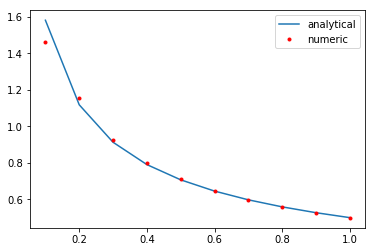

In [2]:
x = np.linspace(0.1, 1, 10)
y = x**0.5

plt.plot(x, 0.5 * x**-0.5, x, np.gradient(y, x, edge_order=2), 'r.')
plt.legend(['analytical', 'numeric'])

You may recall we can fit a polynomial to this data, and then easily get the derivative of the polynomial. By increasing the polynomial order we can improve the derivative estimates to a point. If you start overfitting, you will introduce wiggles into the data.



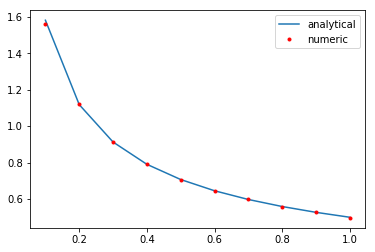

In [3]:
p = np.polyfit(x, y, 8)
dp  = np.polyder(p)

plt.plot(x, 0.5 * x **-0.5, x, np.polyval(dp, x), 'r.')
plt.legend(['analytical', 'numeric'])

Let's briefly review some linear algebra and the connection with derivatives.

A central difference formula is:

$y'(x_i) \approx \frac{y_{i+1} - y_{i-1}}{2h}$

We cannot evaluate this for y<sub>0</sub> or y<sub>-1</sub>. We need a simpler formula for that:

We use a forward formula at the beginning: $y'(x_0) \approx \frac{y_1 - y_0}{h}$

and a backward formula at the end:  $y'(x_{-1}) \approx \frac{y_{-1} - y_{-2}}{h}$

We can express these formulas in matrix algebra form:

$\mathbf{y'} = \mathbf{D} \mathbf{y}$



In [4]:
x, h = np.linspace(0.1, 1, 10000, retstep=True)
y = x**0.5

D = np.zeros((len(x), len(x)))
D += np.diag(np.ones(len(x) - 1) / (2 * h), 1)
D += np.diag(-np.ones(len(x) - 1) / (2 * h), -1)
D[0, 0:2] = np.array([-1, 1]) / h  # forward formula
D[-1, -2:] = np.array([-1, 1]) / h # backward formula
D

array([[-11110.,  11110.,      0., ...,      0.,      0.,      0.],
       [ -5555.,      0.,   5555., ...,      0.,      0.,      0.],
       [     0.,  -5555.,      0., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,      0.,   5555.,      0.],
       [     0.,      0.,      0., ...,  -5555.,      0.,   5555.],
       [     0.,      0.,      0., ...,      0., -11110.,  11110.]])

In [5]:
print(h)
dydx = D @ y

np.allclose(dydx, np.gradient(y, x))

9.000900090009e-05


True

There are more accurate formulas to use for these that use more data points, but in these cases it is better to use `np.gradient` because it already handles these.




## `scipy.misc.derivative`



When we have equations in the form of *functions* rather than data, we can leverage `scipy.misc.derivative`. This function also works by using finite differences, and so it would suffer from the same limitations on accuracy as we saw above with data. Nevertheless, if you don't have a better approach, it might still be useful.



In [19]:
import numpy as np
from scipy.misc import derivative
?derivative

The most crucial step is choosing an appropriate value for dx. Note that `derivative` does not return a function; we have to *wrap* it in a function definition to use it like a function.



True
True


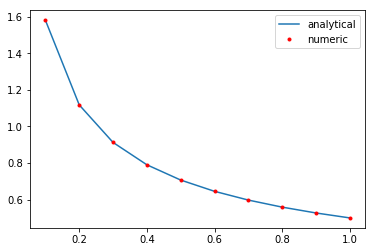

In [7]:
x = np.linspace(0.1, 1, 10)

def f(x):
    return x**0.5

def dfdx(x, dx=1e-5):
    return derivative(f, x, dx)


# alternative approach with list comprehension
_dfdx = np.array([derivative(f, _x, 1e-5) for _x in x])

# alternative 2
__dfdx = np.zeros(x.shape)
for i, _x in enumerate(x):
    __dfdx[i] = derivative(f, _x, 1e-5)

    
print(np.allclose(dfdx(x), _dfdx))
print(np.allclose(dfdx(x), __dfdx))

plt.plot(x, 0.5 * x **-0.5, x, dfdx(x), 'r.')
plt.legend(['analytical', 'numeric'])

We can combine the ideas for data and functions with `scipy.interpolate.interp1d`. This is similar in spirit to using polyfit, but the polynomials are locally fit rather than globally fit through all the data points. As with polyfit, this can result in spurious wiggles being introduced, especially near data points where there are big changes.



In [8]:
from scipy.interpolate import interp1d
?interp1d

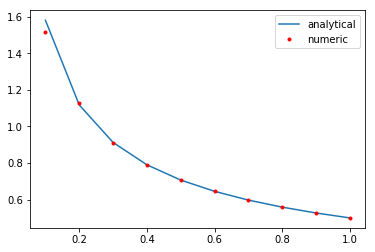

In [9]:
y = x**0.5
af = interp1d(x, y, kind='cubic', bounds_error=False, fill_value='extrapolate')

def dfadx(x, dx):
    return derivative(af, x, dx)

plt.plot(x, 0.5 * x **-0.5, x, dfadx(x, dx=0.005), 'r.')
plt.legend(['analytical', 'numeric'])


## Limitations of numeric derivatives



There are several limitations of numeric derivatives. The biggest one is that they are all *approximations* to the real derivative, and their accuracy depends on how small the spacing between the data points is. If the spacing is too small, however, these methods can suffer from numerical instabilities. These issues are exacerbated with higher order derivatives; derivatives tend to magnify errors in data.

Fitting models to the data leads to analytical models that can be analytically differentiated. Here you have to be aware of the properties of the model, and its derivatives.

The methods above apply to scalar functions of a single variable. It is not convenient to use them for multivariable functions.

[https://numdifftools.readthedocs.io/en/latest/](https://numdifftools.readthedocs.io/en/latest/)




# Symbolic differentiation



[https://docs.sympy.org/latest/tutorial/calculus.html](https://docs.sympy.org/latest/tutorial/calculus.html)

Computer algebra systems have increasingly been able to compute symbolic derivatives of expressions. [sympy](https://docs.sympy.org/latest/index.html) can do some [calculus](https://docs.sympy.org/latest/tutorial/calculus.html), including taking derivatives symbolically.



0.5*x**(-0.5)


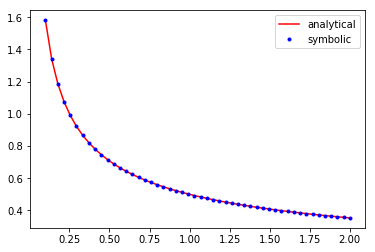

In [10]:
from sympy import *
x = symbols('x')

df = diff(x**0.5, x)
print(df)
df.subs(x, 0.5)

X = np.linspace(0.1, 2)
plt.plot(X, 0.5 * X**-0.5, 'r-', X,  [df.subs(x, a) for a in X], 'b.')
plt.legend(['analytical', 'symbolic'])

For some applications, this is very useful. Symbolic derivatives do not work on programs though, and in some cases there are not simple derivatives to find.




# Automatic differentiation



The third kind of computational derivatives we need to know about is called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (AD). It is completely different from both finite differences and symbolic differentiation. In AD, we use the chain rule to take derivatives of computer programs.

AD solves many of the problems described above:

1.  It is not an approximation like the finite difference approach.
2.  It works on programs, unlike symbolic differentiation

However, these features come at some cost; we have to use an AD library and learn how to write code with it. Most importantly, AD is usually an add-on feature and its implementation introduces some constraints on what can be programmed.

There are several AD frameworks available in Python that have been developed for machine learning applications. The main ones in use today are:

1.  autograd - [https://github.com/HIPS/autograd](https://github.com/HIPS/autograd)
2.  Tensorflow - [https://www.tensorflow.org/](https://www.tensorflow.org/)
3.  pytorch - [https://pytorch.org/](https://pytorch.org/)

We will focus on autograd for the rest of the semester.

You can install it like this:



In [11]:
!pip install autograd

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


autograd works by modifying `numpy` so that derivatives can be automatically computed.

The most important step in using autograd is to import the autograd version of numpy. Not doing this will lead to errors eventually.



In [12]:
import autograd.numpy as np


## Derivatives of scalar functions



Autograd provides four basic derivative functions. We first consider the derivative of a scalar function, i.e. a function of several arguments that outputs a number. There are two functions for this: `grad` and `elementwise_grad`.



In [13]:
from autograd import grad, elementwise_grad
?grad

You use grad when your function outputs a single number, and you want a single derivative of that function with respect to an argument. For example, it could be an objective function.



In [14]:
from autograd import elementwise_grad
??elementwise_grad
# A vectorized form of grad

You use elementwise\_grad when you might use an array as input, and you get an array of values out, but you want the derivative of each element in the output with respect to the corresponding element in the input. This is still a *scalar* function in the sense that each element in the input produces one element in the output.

Here is an example usage similar to the examples we have used so far.



In [16]:
def f(x):
    return x**0.5


dfg = grad(f)

In [17]:
_x = np.array([0.5, 0.6])
print(f(_x))
dfg(_x), 0.5 * _x**-0.5

[0.70710678 0.77459667]


TypeError: Grad only applies to real scalar-output functions. Try jacobian or elementwise_grad.

True

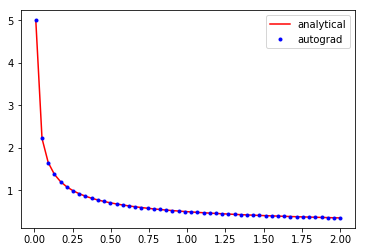

In [18]:
df = elementwise_grad(f)  # This returns a callable function

x = np.linspace(0.01, 2)

plt.plot(x, 0.5 * x**-0.5, 'r-', x, df(x), 'b.')
plt.legend(['analytical', 'autograd'])
np.allclose(0.5 * x**-0.5, df(x))

The AD derivatives are identical within tolerance to the analytical formula because autograd simply applies the chain rule to the program to evaluate the derivatives.

**Limitation** Derivatives with integers is not well-defined since integers are not continuous.



In [65]:
df(1.0)

0.5

It might not seem like a big deal that this works. The significance really shows when you have more complex programs. This Rube-Goldberg program is equivalent to the previous program. You could work out the derivative by the chain rule your self, but autograd has no problem doing this through all the operations and loops!



True

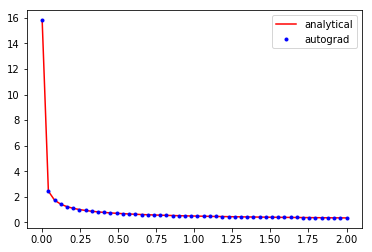

In [70]:
def g(x):
    return 1.0 / x

def h(x):
    return 1.0 / x

def f(x):
    a = 2.0 * x
    b = a**2
    c = b / 4.0
    d = c**0.5
    for i in range(5):
        d = d + 1

    for i in range(5):
        d = d - 1

    e = np.sqrt(d)
    
    f = g(h(e))
    return f

df = elementwise_grad(f)  # This returns a callable function

x = np.linspace(0.001, 2)

plt.plot(x, 0.5 * x**-0.5, 'r-', x, df(x), 'b.')
plt.legend(['analytical', 'autograd'])
np.allclose(0.5 * x**-0.5, df(x))

Of course, autograd cannot make derivatives where they are not defined. The derivative of the square root function is not defined at $x=0$, and we get warnings and a `nan` result if we try to evaluate it there.



In [71]:
df(0.0)

/Users/jkitchin/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
/Users/jkitchin/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/jkitchin/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/jkitchin/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


nan


## Derivatives of multivalue functions - Jacobian



Autograd really starts to shine when we have vector functions.  If we have a function that takes an input with $n$ and produces $m$ outputs, then we frequently need to compute the derivatives of the output with respect to the inputs. These are defined by:

$\mathbf{J}_{ij} = \frac{\partial f_i}{\partial x_j}$

autograd provides the `jacobian` function for this. Let's consider an example:

$f_1(x, y) = x^2 y$

$f_2(x, y) = 5 x + \sin(y)$

The Jacobian of this system is:

\begin{equation}
\left[\begin{array}{cc}
2 x y & x^2 \\
5 & \cos y \\
\end{array}\right]
\end{equation}



In [72]:
from autograd import jacobian

def f(X):
    x, y = X
    return np.array([x**2 * y, 
                     5 * x + np.sin(y)])

Jf = jacobian(f)

# now show the equivalence
x, y = 0.5, 0.5
print(Jf(np.array([x, y])))
print(np.array([[2 * x * y, x**2], 
                [5, np.cos(y)]]))

[[ 0.5         0.25      ]
 [ 5.          0.87758256]]
[[ 0.5         0.25      ]
 [ 5.          0.87758256]]


**Limitation** Note the explicit use of arrays in the above code. Autograd requires you to use arrays explicitly most of the time, and you can get errors if you are lazy and use lists/tuples.

We use Jacobians in a variety of applications, but one important one is for changing variables in integrations, presumably because this results in a simpler integral.

$\int \int_R f(x, y) dx dy = \int \int_{R'} f(x(u, v), y(u, v)) \left|\frac{\partial(x, y)}{\partial(u, v)}\right| du dv$

Where $\left|\frac{\partial(x, y)}{\partial(u, v)}\right|$ is defined as the determinant of the Jacobian:

$\left|\begin{array}{cc}
\frac{\partial x}{\partial u} & \frac{\partial x}{\partial v} \\
\frac{\partial y}{\partial u} & \frac{\partial y}{\partial v}
\end{array}\right|$

Here is an example we work out that is adapted from: [http://www.stat.rice.edu/~dobelman/notes_papers/math/Jacobian.pdf](http://www.stat.rice.edu/~dobelman/notes_papers/math/Jacobian.pdf)

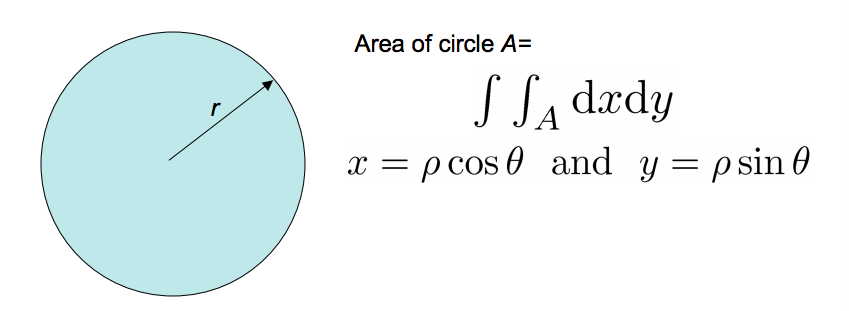

Executing that double integral in cartesian coordinates is not convenient because the integral limits would be a function for $y$. If we instead switch to polar coordinates, then we have the simpler limits of $\rho$ from 0 to $r$, and $\theta$ from 0 to $2\pi$. There is no $f(x, y)$ here, the integrand is just 1.

This is a double integral, and we use ~scipy.integrate.dblquad.



In [97]:
from scipy.integrate import dblquad
?dblquad

Return the double (definite) integral of \`\`func(y, x)\`\` from \`\`x = a..b\`\`
and \`\`y = gfun(x)..hfun(x)\`\`.

We want:

$\int_{\rho=0}^{\rho=1} \int_{\theta=0}^{\theta=2\pi} det(J) d\theta d\rho = \pi$

That leads to this implementation:



In [87]:
def f(P):
    rho, theta = P
    # Be explicit about returning an array
    return np.array([rho * np.cos(theta), 
                     rho * np.sin(theta)])

jf = jacobian(f)

# be explicit about inputting arrays
jf(np.array([0.0, 0.1]))

array([[ 0.99500417,  0.        ],
       [ 0.09983342,  0.        ]])

In [74]:
def integrand(rho, theta):
    J = jf(np.array([rho, theta]))
    return np.linalg.det(J)

# integrand(y, x)
xa, xb = 0, 2 * np.pi
ya, yb = 0, 1

dblquad(integrand, xa, xb, ya, yb)

(3.141592653589793, 3.487868498008632e-14)

And the expected answer. Compare that to the cartesian coordinate system:

$\int_{x=-1}^{x=1} \int_{y=-\sqrt{1 - x^2}}^{y=\sqrt{1 - x^2}} dy dx$



In [1]:
def integrand(y, x):
    return 1

def yl(x):
    return -np.sqrt(1 - x**2)

def yu(x):
    return np.sqrt(1 - x**2)

dblquad(integrand, -1, 1, yl, yu)

(3.1415926535897967, 2.000470900043183e-09)

The answer is the same, but the integral limits are more complex. Of course, one can invoke Kitchin's conservation of complexity law here; we can give up the complexity of the limits if we take on the complexity of autograd.




## Hessians



The [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) is a square matrix of second-order partial derivatives of a scalar-valued function.

$\mathbf{H}_{ij} = \frac{\partial^2 f}{\partial x_i x_j}$

`autograd.hessian` also returns a callable function.



In [91]:
from autograd import hessian

def f(X):
    x, y = X
    return x**2 + y**2

H = hessian(f)

H(np.array([5, 0.5]))

array([[ 2.,  0.],
       [ 0.,  2.]])

The Hessian is used to classify what kind of stationary points have been found. It is also used in some optimization algorithms.




## Applications to optimization



In [93]:
from scipy.optimize import minimize
?minimize

We will consider the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), which has a minimum at (1, 1) with a value of 0. The standard optimization approach is shown here for comparison.



In [94]:
def rosenbrock(X):
    x, y = X
    return (1 - x)**2 + 100 * (y - x**2)**2

sol = minimize(rosenbrock, [1, 0])
print(sol)

      fun: 2.112634678287409e-11
 hess_inv: array([[ 0.49378146,  0.98756105],
       [ 0.98756105,  1.98011829]])
      jac: array([ -2.90564340e-07,   2.72884382e-08])
  message: 'Optimization terminated successfully.'
     nfev: 148
      nit: 32
     njev: 37
   status: 0
  success: True
        x: array([ 0.9999954,  0.9999908])


The solution is pretty good, but we can get a better answer if we provide the Jacobian. Usually you are expected to derive and implement this. We do it in one like with autograd.



In [95]:
df = grad(rosenbrock)

sol_j = minimize(rosenbrock, [1, 0], jac=df)
print(sol_j)

      fun: 1.9292283401977483e-14
 hess_inv: array([[ 0.49289915,  0.98579551],
       [ 0.98579551,  1.97658546]])
      jac: array([ -2.94106501e-07,   8.15718604e-09])
  message: 'Optimization terminated successfully.'
     nfev: 37
      nit: 32
     njev: 37
   status: 0
  success: True
        x: array([ 0.99999986,  0.99999972])


Note that the function is closer to zero (although it was small to start with).

Finally, we get an even better answer if we also provide the Hessian, and use an algorithm that uses the Hessian (most of them do not).



In [96]:
hf = hessian(rosenbrock)
minimize(rosenbrock, [1, 0], jac=df, hess=hf, method='dogleg')

     fun: 4.9303806576313238e-30
    hess: array([[ 802., -400.],
       [-400.,  200.]])
     jac: array([ -8.88178420e-14,   4.44089210e-14])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 1
     nit: 1
    njev: 2
  status: 0
 success: True
       x: array([ 1.,  1.])

Note we get an almost exact answer, with only two function evaluations!

You can see that the Hessian returned by this solver is identical to the Hessian we would compute.



In [1]:
hf(np.array([1.0, 1.0]))

array([[ 802., -400.],
       [-400.,  200.]])

Note that in the example where we just provided the Jacobian that the Hessian is approximated. You can see that here. It is pretty close, but not exact.



In [1]:
print(np.linalg.inv(sol_j.hess_inv))

[[ 802.02588665 -399.99966532]
 [-399.99966532  200.00039681]]


# Summary



Today we reviewed computational approaches to taking derivatives. The star of this lecture is automatic differentiation.

Autograd is pretty good, but it has some limitations. You should review [these best practices](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md#supported-and-unsupported-parts-of-numpyscipy). One of the reasons we reviewed the first two methods is that we need to be able to verify results sometimes, and those methods are useful for that.

Next time we will look at several applications of AD in calculus, science and engineering. After that, we will return to nonlinear regression and conclude with an introduction to machine learning.

